In [8]:
import matplotlib.pyplot as plt
%matplotlib inline

from tensorflow import data as tf_data
import os
import keras
from keras import layers
from keras.applications import EfficientNetB0

IMAGE_SIZE = (224, 224) # Размер определен выбором модели
BATCH_SIZE = 128
IMAGE_PATH = './dataset/'

Удаляем поврежденные изображения

In [12]:
num_skipped = 0 # счетчик поврежденных файлов
for folder_name in os.listdir(IMAGE_PATH): # перебираем папки
    folder_path = os.path.join(IMAGE_PATH, folder_name) # склеиваем путь
    for fname in os.listdir(folder_path): # получаем список файлов в папке
        fpath = os.path.join(folder_path, fname) # получаем путь до файла
        try:
            fobj = open(fpath, "rb") # пытаемся открыть файл для бинарного чтения (rb)
            is_jfif = b"JFIF" in fobj.peek(10) # получаем первые 10 байт из файла и ищем в них бинарный вариант строки JFIF
        finally:
            fobj.close() # Закрываем файл

        if not is_jfif: # Если не нашли JFIF строку
            # Увеличиваем счетчик
            num_skipped += 1
            # Удаляем поврежденное изображение
            os.remove(fpath)

print(f"Удалено изображений: {num_skipped}")

Удалено изображений: 0


In [13]:
import shutil

shutil.copytree('./dataset','./dataset_updated', dirs_exist_ok=True)
IMAGE_PATH = './dataset_updated'

Берем 10 случайных пород собак генерируем датасет

In [15]:
from random import randint

IMAGE_PATH = './dataset_updated'
while len(os.listdir(IMAGE_PATH)) > 10:
    folders = os.listdir(IMAGE_PATH)
    folder_to_remove = folders[randint(0, len(folders) - 1)]
    shutil.rmtree(IMAGE_PATH + f"/{folder_to_remove}")

In [35]:
file_count = 0
for folder in os.listdir('./dataset_updated'):
    file_count += len(os.listdir(os.path.join('./dataset_updated', folder)))
    print(file_count)

print(file_count)

196
391
579
729
897
1047
1228
1420
1579
1785
1785


In [16]:
train_ds, val_ds = keras.utils.image_dataset_from_directory(
    IMAGE_PATH, # путь к папке с данными
    validation_split=0.2, # отщепляем 20% на проверочную выборку
    subset="both", # указываем, что необходимо вернуть кортеж из обучающей и проверочной выборок ("training", "validation" или "both")
    seed=42,  # воспроизводимость результата генерации (результаты с одинаковым числом - одинаковы),
    shuffle=True, # перемешиваем датасет
    image_size=IMAGE_SIZE, # размер генерируемых изображений
    batch_size=BATCH_SIZE, # размер мини-батча
)

Found 1785 files belonging to 10 classes.
Using 1428 files for training.
Using 357 files for validation.


Определяем метки датасета

In [17]:
# Определяем список имен классов
CLASS_LIST = sorted(os.listdir(IMAGE_PATH))

# Определяем количества классов
CLASS_COUNT = len(CLASS_LIST)

# Вывод результата
print(f'Количество классов: {CLASS_COUNT}')
print(f'Метки классов: {CLASS_LIST}')

Количество классов: 10
Метки классов: ['Australian_terrier', 'Beagle', 'Blenheim_spaniel', 'Eskimo_dog', 'Greater_Swiss_Mountain_dog', 'Kuvasz', 'Pembroke', 'Siberian_husky', 'Standard_poodle', 'Tibetan_terrier']


Выполняем аугментацию данных

In [18]:
img_augmentation_layers = [
    layers.RandomRotation(factor=0.2), # Вращаем изображение в пределах 15%
    layers.RandomTranslation(height_factor=0.2, width_factor=0.2), # Сдвиг на 10% по вертикали и горизонтали
    layers.RandomFlip(), # Отражение по вертикали и горизонтали
    layers.RandomContrast(factor=0.15), # Изменяем контрастность на 10%
]


def img_augmentation(images):
    # Слои - это функции, которые мы последовательно применяем к входным данным
    for layer in img_augmentation_layers:
        images = layer(images)
    return images

In [19]:
# Применяем `img_augmentation` к обучающей выборке
train_ds = train_ds.map(
    lambda img, label: (img_augmentation(img), keras.ops.one_hot(label, CLASS_COUNT)), # One-hot кодирование
    num_parallel_calls=tf_data.AUTOTUNE, # число потоков для обработки в map (автонастройка зависит от возможностей процессора)
)

val_ds = val_ds.map(
    lambda img, label: (img, keras.ops.one_hot(label, CLASS_COUNT)), # One-hot кодирование
    num_parallel_calls=tf_data.AUTOTUNE, # число потоков для обработки в map (автонастройка зависит от возможностей процессора)
)

# Предварительная выборка примеров в память GPU или оперативную память
# Помогает максимально эффективно использовать графический процессор
train_ds = train_ds.prefetch(tf_data.AUTOTUNE)
val_ds = val_ds.prefetch(tf_data.AUTOTUNE)

In [20]:
# Определяем дополнительный функционал
def show_plot(history):
    acc = history.history['acc']
    epochs = range(1, len(acc) + 1)
    val_acc = history.history['val_acc']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs = range(1, len(acc) + 1)
    plt.plot(epochs, acc, 'r', label='Точность на обучающей выборке')
    plt.plot(epochs, val_acc, 'b', label='Точность на проверочной выборке')
    plt.title('График точности на обучающей и проверочной выборках')
    plt.legend()
    plt.figure()
    plt.plot(epochs, loss, 'r', label='Потери на обучающей выборке')
    plt.plot(epochs, val_loss, 'b', label='Потери на проверочной выборке')
    plt.title('График потерь на обучающей и проверочной выборках')
    plt.legend()
    plt.show()

Берём предобученную модель и выполняем fine tuning

In [21]:
def build_model(num_classes):
    inputs = layers.Input(shape=(IMAGE_SIZE[0], IMAGE_SIZE[1], 3))
    model = EfficientNetB0(include_top=False, input_tensor=inputs, weights="imagenet")

    # Заморозка предобученных весов
    model.trainable = False

    # Замена верхних слоев
    x = layers.GlobalAveragePooling2D(name="avg_pool")(model.output)
    x = layers.BatchNormalization()(x)

    top_dropout_rate = 0.2
    x = layers.Dropout(top_dropout_rate, name="top_dropout")(x)
    outputs = layers.Dense(num_classes, activation="softmax", name="pred")(x)

    # Компилируем
    model = keras.Model(inputs, outputs, name="EfficientNet")
    optimizer = keras.optimizers.Adam(learning_rate=1e-2)
    model.compile(
        optimizer=optimizer, loss="categorical_crossentropy", metrics=["acc"]
    )
    return model

In [22]:
epochs = 20

callbacks = [
    keras.callbacks.ModelCheckpoint(filepath = './best_model_pretrain.keras',
                             monitor = 'val_acc',
                             save_best_only = True,
                             mode = 'max',
                             verbose = 0)
]

model = build_model(num_classes=CLASS_COUNT)


history = model.fit(train_ds, epochs=epochs, validation_data=val_ds, callbacks=callbacks)

Epoch 1/20
12/12 ━━━━━━━━━━━━━━━━━━━━ 16s 925ms/step - acc: 0.4947 - loss: 1.7772 - val_acc: 0.8627 - val_loss: 0.3172
Epoch 2/20
12/12 ━━━━━━━━━━━━━━━━━━━━ 11s 814ms/step - acc: 0.7559 - loss: 0.8825 - val_acc: 0.9244 - val_loss: 0.2086
Epoch 3/20
12/12 ━━━━━━━━━━━━━━━━━━━━ 11s 803ms/step - acc: 0.7983 - loss: 0.7620 - val_acc: 0.8992 - val_loss: 0.2633
Epoch 4/20
12/12 ━━━━━━━━━━━━━━━━━━━━ 11s 816ms/step - acc: 0.7989 - loss: 0.7532 - val_acc: 0.8964 - val_loss: 0.2630
Epoch 5/20
12/12 ━━━━━━━━━━━━━━━━━━━━ 11s 820ms/step - acc: 0.8143 - loss: 0.6891 - val_acc: 0.9104 - val_loss: 0.2127
Epoch 6/20
12/12 ━━━━━━━━━━━━━━━━━━━━ 11s 833ms/step - acc: 0.8033 - loss: 0.7395 - val_acc: 0.8908 - val_loss: 0.2450
Epoch 7/20
12/12 ━━━━━━━━━━━━━━━━━━━━ 11s 807ms/step - acc: 0.8042 - loss: 0.6883 - val_acc: 0.8852 - val_loss: 0.2310
Epoch 8/20
12/12 ━━━━━━━━━━━━━━━━━━━━ 11s 805ms/step - acc: 0.8121 - loss: 0.6727 - val_acc: 0.8936 - val_loss: 0.2421
Epoch 9/20
12/12 ━━━━━━━━━━━━━━━━━━━━ 11s 809ms/

Epoch 1/4
12/12 ━━━━━━━━━━━━━━━━━━━━ 17s 970ms/step - acc: 0.8588 - loss: 0.4988 - val_acc: 0.9300 - val_loss: 0.2177
Epoch 2/4
12/12 ━━━━━━━━━━━━━━━━━━━━ 11s 868ms/step - acc: 0.8763 - loss: 0.4260 - val_acc: 0.9300 - val_loss: 0.2183
Epoch 3/4
12/12 ━━━━━━━━━━━━━━━━━━━━ 12s 890ms/step - acc: 0.8772 - loss: 0.4357 - val_acc: 0.9244 - val_loss: 0.2182
Epoch 4/4
12/12 ━━━━━━━━━━━━━━━━━━━━ 11s 883ms/step - acc: 0.8814 - loss: 0.4066 - val_acc: 0.9272 - val_loss: 0.2180


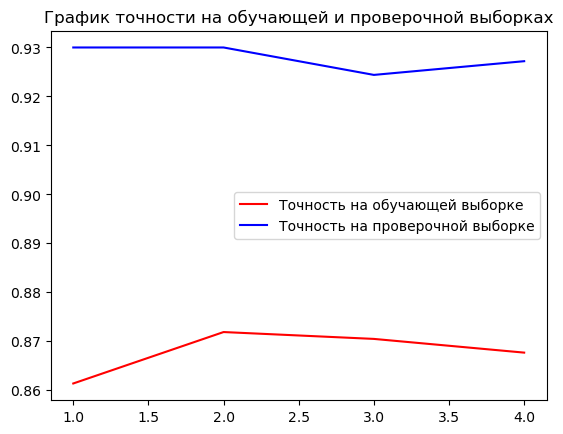

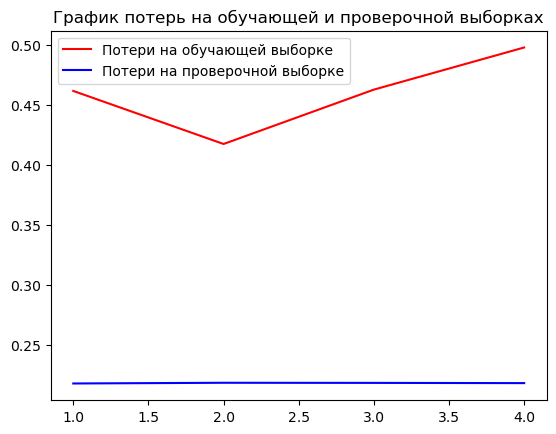

In [23]:
def unfreeze_model(model):
    # Мы размораживаем 20 верхних слоев за исключением BatchNormalization
    for layer in model.layers[-20:]:
        if not isinstance(layer, layers.BatchNormalization):
            layer.trainable = True
    # В оптимизаторе устанавливаем маленький шаг обучения
    optimizer = keras.optimizers.Adam(learning_rate=1e-5)
    model.compile(
        optimizer=optimizer, loss="categorical_crossentropy", metrics=["acc"]
    )


unfreeze_model(model)

epochs = 4
history = model.fit(train_ds, epochs=epochs, validation_data=val_ds)
show_plot(history)

Проверим модель

In [24]:
os.listdir('./')

['best_model_pretrain.keras',
 'dataset',
 'dataset_updated',
 'Homework_18.ipynb',
 'leonberg_test.jpg',
 'test.png']

In [25]:
os.listdir('./dataset_updated')

['Australian_terrier',
 'Beagle',
 'Blenheim_spaniel',
 'Eskimo_dog',
 'Greater_Swiss_Mountain_dog',
 'Kuvasz',
 'Pembroke',
 'Siberian_husky',
 'Standard_poodle',
 'Tibetan_terrier']

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


(-0.5, 223.5, 223.5, -0.5)

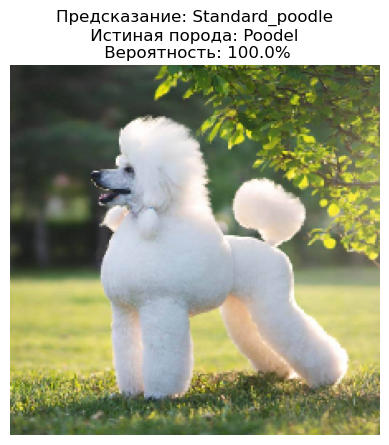

In [31]:
TEST_IMG='./poodel_test.jpg'

img = keras.utils.load_img(TEST_IMG, target_size=(IMAGE_SIZE[0], IMAGE_SIZE[1])) # Загружаем картинку
plt.imshow(img)


img_array = keras.utils.img_to_array(img) # Преобразуем картинку в тензор
img_array = keras.ops.expand_dims(img_array, 0)  # Создание дополнительного измерения для батча

predictions = model.predict(img_array)


plt.title("Предсказание: %s\n Истиная порода: Poodel \n Вероятность: %2.1f%%" %
 (CLASS_LIST[keras.ops.argmax(predictions)],
  keras.ops.max(predictions)*100)  ) # Вывод метки
plt.axis("off")
